In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/ABRO/"
!ls "drive/My Drive/ABRO/ADNI/"

from IPython.display import clear_output
# !cd "drive/My Drive/ABRO/Atlas/" && unrar e MASKS_MNI2mm.rar

Mounted at /content/drive
AD  CN


In [ ]:
import nibabel as nib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob


width = 80
height = 80
depth = 80
nLabel = 2

fRange1 = slice(6,86)
fRange2 = slice(16,96)
fRange3 = slice(6,86)

In [ ]:
def norm(A):
       return A#(A-np.amin(A))/(np.amax(A)-np.amin(A))

_data = []
_labels = []
G=glob.glob(data_path+'ADNI/AD/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(1)


G=glob.glob(data_path+'ADNI/CN/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(0)


clear_output()
_data = np.array(_data, dtype=np.float32)#[...,np.newaxis]
_labels = np.array(_labels)

print('_data.shape=>', _data.shape)
print('_labels.shape=>', _labels.shape)

_data.shape=> (145, 80, 80, 80)
_labels.shape=> (145,)


In [ ]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical

# oh_labels = to_categorical(_labels)

x_train, x_test, y_train, y_test  = train_test_split(_data, _labels,
                              train_size=.8,random_state=123,shuffle=True)
del _data
del _labels

print('x_train.shape=>', x_train.shape)
print('y_train.shape=>', y_train.shape)
print('x_test.shape=>', x_test.shape)
print('y_test.shape=>', y_test.shape)



x_train.shape=> (116, 80, 80, 80)
y_train.shape=> (116,)
x_test.shape=> (29, 80, 80, 80)
y_test.shape=> (29,)


In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence
import math
from numpy import random
from tensorflow.keras.preprocessing.image import random_rotation
import tensorflow as tf

class Generator(Sequence):
    # Class is a dataset wrapper for better training performance
    def __init__(self, x_dataset, y_dataset, is_train=True, batch_size=4):
        self.is_train = is_train
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(self.x_dataset))

    def __len__(self):
        return math.ceil(len(self.x_dataset) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#        print(inds)
        batch_x = self.x_dataset[inds,...]

        batch_x = batch_x[...,tf.newaxis]
        batch_y = self.y_dataset[inds]
        return batch_x,batch_y 
    def on_epoch_end(self):
        if self.is_train:
            np.random.shuffle(self.indices)
    


Dimension of the MRI scan is: (80, 80, 80)


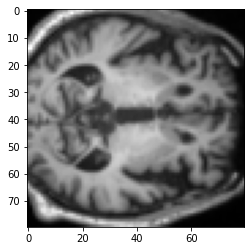

In [ ]:
# data = train_dataset.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
image = x_train[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

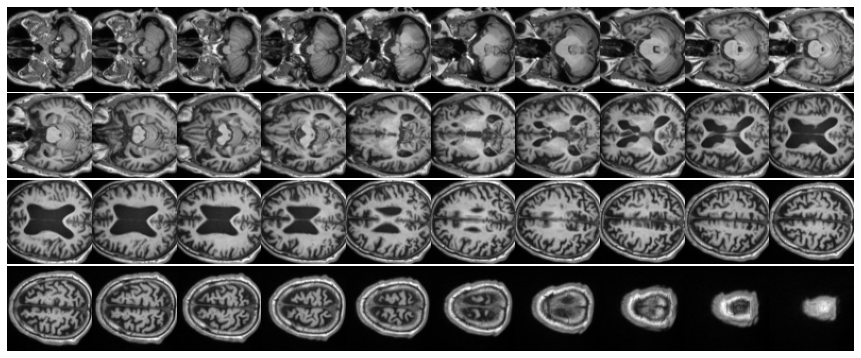

In [ ]:

def plot_slices(num_rows, num_columns, width, height, data,cmap='gray'):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    if len(data.shape)==3:
        data = np.transpose(data)
        data = np.reshape(data, (num_rows, num_columns, width, height))
    else:
        data = np.transpose(data,[3,1,0,2])
        data = np.reshape(data, (num_rows, num_columns, width, height, 3))

    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            t_data = data[i][j]     
            axarr[i, j].imshow(t_data*255, cmap=cmap)
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0.02, right=1, bottom=0, top=1)
    plt.show()


plot_slices(4, 10, 80, 80, image[:, :, ::2])


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(width=80, height=80, depth=80):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    x = (inputs)

    x = layers.Conv3D(filters=8, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)


    x = layers.Flatten()(x)

    x = layers.Dense(units=512, activation="sigmoid")(x)
    x = layers.Dropout(0.05)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
# model = get_model(width=80, height=80, depth=80)
model.summary()

In [ ]:
# Compile model.
# initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=1000, decay_rate=0.95, staircase=True
# )
tf.random.set_seed(123)
#########################################
train_data_generator = Generator(x_train,y_train)
test_data_generator = Generator(x_test,y_test,is_train=False)
#########################################
model = get_model(width=80, height=80, depth=80)
# model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.0005),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    data_path+"chkp/3d_MRI_classification_1.h5" #, save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 30
model.fit(
    train_data_generator,
    validation_data=test_data_generator,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)


Epoch 1/30
29/29 - 3s - loss: 1.5578 - acc: 0.6121 - val_loss: 1.3271 - val_acc: 0.4138
Epoch 2/30
29/29 - 3s - loss: 0.6466 - acc: 0.6121 - val_loss: 0.6295 - val_acc: 0.6552
Epoch 3/30
29/29 - 3s - loss: 0.6171 - acc: 0.6897 - val_loss: 0.6634 - val_acc: 0.5172
Epoch 4/30
29/29 - 3s - loss: 0.6030 - acc: 0.7155 - val_loss: 0.6273 - val_acc: 0.6552
Epoch 5/30
29/29 - 3s - loss: 0.5662 - acc: 0.7069 - val_loss: 0.6048 - val_acc: 0.7586
Epoch 6/30
29/29 - 3s - loss: 0.5095 - acc: 0.7845 - val_loss: 0.5800 - val_acc: 0.6207
Epoch 7/30
29/29 - 3s - loss: 0.4732 - acc: 0.8534 - val_loss: 0.5760 - val_acc: 0.6552
Epoch 8/30
29/29 - 3s - loss: 0.3975 - acc: 0.8621 - val_loss: 0.5921 - val_acc: 0.6552
Epoch 9/30
29/29 - 3s - loss: 0.3627 - acc: 0.9052 - val_loss: 0.4832 - val_acc: 0.7931
Epoch 10/30
29/29 - 3s - loss: 0.2977 - acc: 0.9310 - val_loss: 0.5516 - val_acc: 0.7241
Epoch 11/30
29/29 - 3s - loss: 0.2153 - acc: 0.9741 - val_loss: 0.4355 - val_acc: 0.8276
Epoch 12/30
29/29 - 3s - loss:

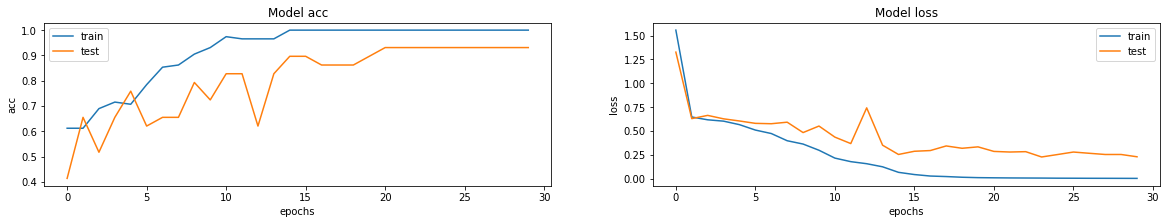

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "test"])


In [ ]:
# Load best weights.
model.load_weights(data_path+"chkp/3d_MRI_classification_1.h5")
prediction = model.predict(x_test[...,np.newaxis]) ##np.expand_dims(x_test[0], axis=0)
# prediction = softmax(prediction) 

# for _p in range(len(prediction)):
#     scores = np.array([1 - prediction[_p], prediction[_p]])
#     class_names = ["normal", "abnormal"]
#     print('Real label is =>',class_names[y_test[_p]])
#     score = scores.max()
#     name = class_names[scores.argmax()]
#     print(
#         "This model is %.2f percent confident that MRI scan is %s"
#         % ((score), name)
#     )
#     print('<##>'*10)


y_pred = np.where(prediction<0.5,0,1)[:,0]
y_true = y_test

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[12  0]
 [ 2 15]]
Accuracy 0.9310344827586207
Precision 1.0
Recall 0.8823529411764706
